# **GAN 구현 코드 과제**
---
- 출제자 : 장현빈
- 기수/이름 :

## **과제 목차**




  [1] Vanilla GAN 구현\
    [2] DCGAN 구현

## **Vanilla GAN 구현**

관련 논문: Implementation of Vanilla GAN\
(https://papers.nips.cc/paper/5423-generative-adversarial-nets.pdf)

###**0. 모델 구조**

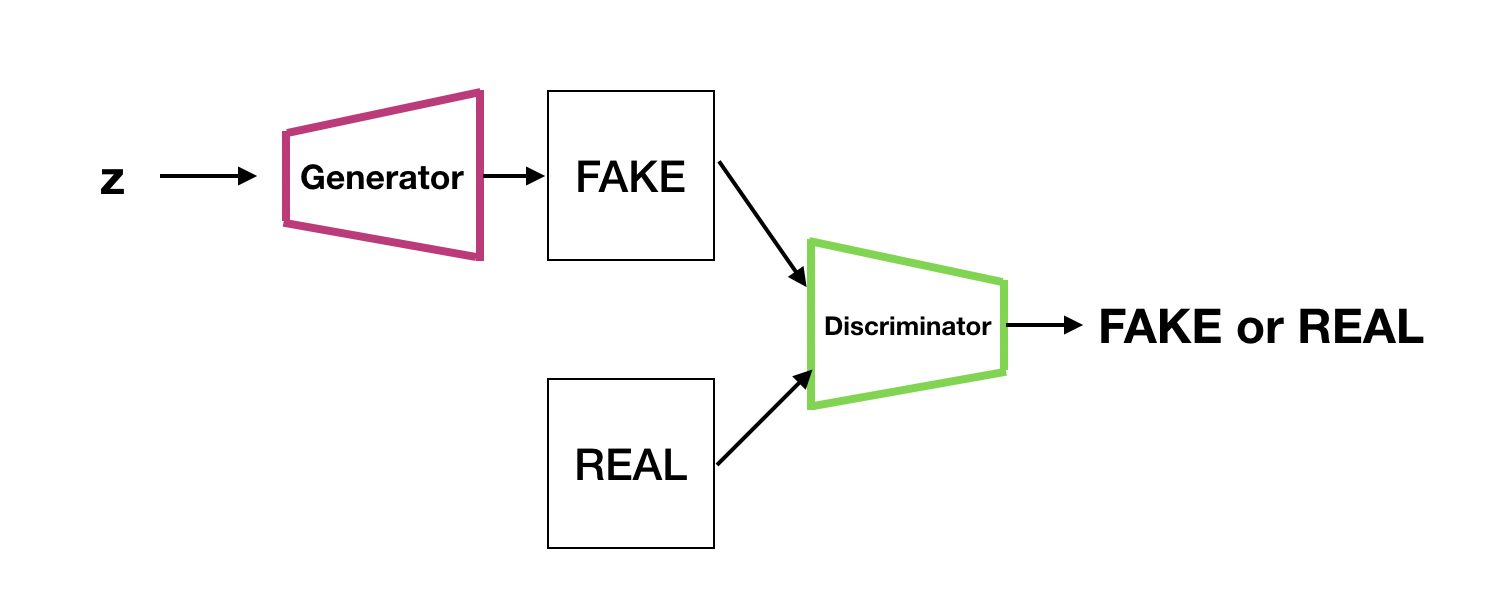

**GAN(Generative adversarial network) 기본 구조!**
- GAN = Generator + Discriminator
- Generator는 Fake data를 생성하고, Discriminator는 Fake와 Real을 구분한다!\
Generator는 Discriminator를 속이기 위해서 점점 더 실제와 유사한 Fake data를 생성하게 되고,\
Discriminator는 Fake와 Real data를 점점 더 잘 구분하게 된다.

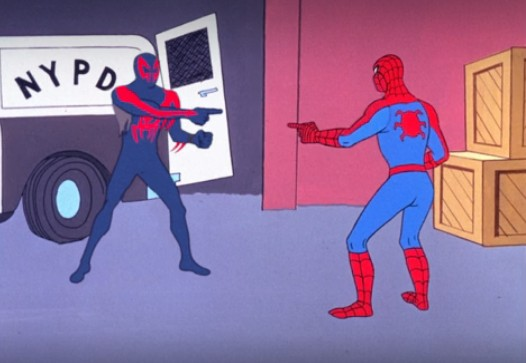

**MNIST Dataset을 input으로 Vanilla GAN 구현해보기!**

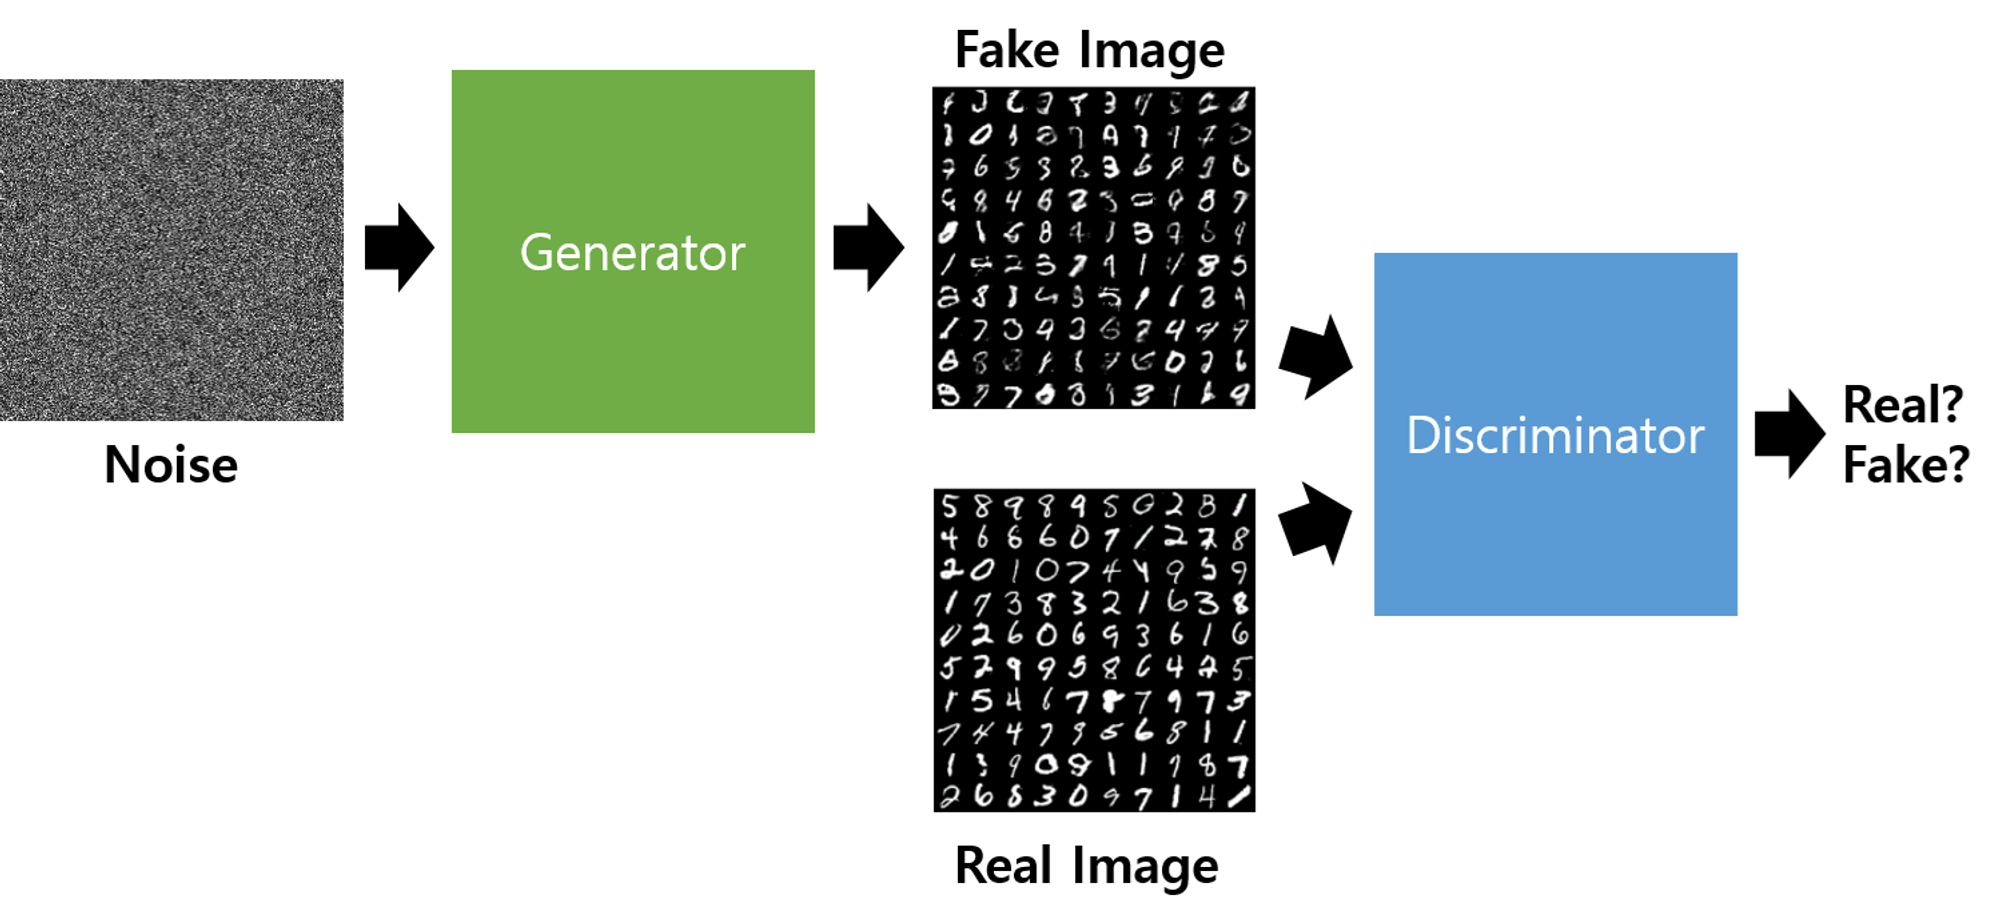

- **Generator**
    - Input: 100 dimension noise vector (z)
    - Output: MNIST image와 동일한 크기와 형식의 fake image
    - Generator는 noise vector z를 입력 받아서 **'진짜 처럼 보이는 가짜 이미지'**를 생성하는 것이 목표!

- **Discriminator**
    - Input : 실제 MNIST image
    - Output: input이 Real image일 때 1, Fake image일 때 0을 출력
    - Discriminator는 Real과 Fake를 잘 구분하는 것이 목표!

- **Latent space**
    - Latent space = 원하는 이미지를 생성할 수 있는 noise가 분포하는 공간
    - random noise에서 이미지를 생성해내는 것이므로,\
    noise의 차원 = **Latent space의 차원**
    - (아래 구현에서는) Latent space 차원을 100으로 설정하여 100 차원의 noise input이 있을 때, Fake image를 생성!

###**1. 라이브러리 임포트**

In [ ]:
import argparse
import os
import numpy as np
import math
import itertools
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import seaborn as sn

import torchvision.transforms as transforms
from torchvision import datasets

import torch
from torch.utils.data import DataLoader
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

### **2. Hyperparameter 설정**

- latent_dim = 100: Random noise z의 차원을 100으로 설정
- normal_init: 네트워크 가중치를 정규 분포로 초기화



In [ ]:
batch_size = 128
img_size = 28
n_channels = 1
n_classes = 10

latent_dim = 100

device = 'cuda' if torch.cuda.is_available() else 'cpu'

seed = 5
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

def normal_init(m, mean, std):
    if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
        m.weight.data.normal_(mean, std)
        m.bias.data.zero_()

### **3. MNIST Dataset 로드**

- MNIST dataset:\
28x28 pixel 흑백 필기체 이미지 6만 개

In [ ]:
transform = transforms.Compose([
  transforms.ToTensor(),
  transforms.Normalize(mean=(0.5,), std=(0.5,))
])

mnist_train  = datasets.MNIST(root='data', download=True, train=True, transform=transform)
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True)

In [ ]:
fig,axes = plt.subplots(2,5,figsize=(2*5,2.5*2))

examples = enumerate(train_loader)
_, (ex_data, ex_targets) = next(examples)

for i in range(10):
    ax = axes[i//5,i%5]
    ax.imshow(ex_data[i][0],cmap='gray')
    ax.set_title('Label: {}'.format(ex_targets[i]))

plt.show()

### **4. Vanilla GAN 구현**

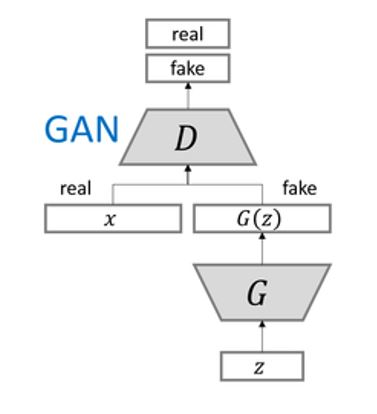

- Generator: noise z를 가지고 Fake image 생성!
- Discriminator: Real image와 Fake image 구분!\
Real로 판별하면 1, Fake로 판별하면 0 으로 라벨링
- Vanilla GAN이므로, Fullcy Connected Layers들로 구성

### **(1) Generator module**

- (100,) input to Full Connected Layer -> Create (784,) Output -> Reshape to (1,28,28)


In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        def block(in_feat, out_feat,normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, momentum=0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(latent_dim, 128,normalize=True),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(n_channels*img_size*img_size)),
            nn.Tanh()
        )

    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

    def forward(self, z):
        img = self.model(z.view(z.size(0),-1))
        img = img.view(img.size(0), n_channels,img_size,img_size)
        return img

**'block' 함수 정의:**
```
def block(in_feat, out_feat,normalize=True):
    layers = [nn.Linear(in_feat, out_feat)]
    if normalize:
        layers.append(nn.BatchNorm1d(out_feat, momentum=0.8))
    layers.append(nn.LeakyReLU(0.2, inplace=True))
    return layers
```

'self.model'
```
self.model = nn.Sequential(
  *block(latent_dim, 128, normalize=True),
  *block(128, 256),
  *block(256, 512),
  *block(512, 1024),
  nn.Linear(1024, int(n_channels*img_size*img_size)),
  nn.Tanh()
)
```
- 각각의 block은 (input_feat, out_feat) 형태로 구성, Batch Normalization이 이루어짐.
- Tanh Activation Function을 사용하여 출력 결과를 -1과 1 사이의 값으로 조정, 이미지 픽셀값의 범위로 사용.

**'weight_init' 함수 정의:**
```
def weight_init(self, mean, std):
    for m in self._modules:
        normal_init(self._modules[m], mean, std)
```
- 모델 가중치를 초기화하는 데 사용.

**Forward method 정의:**
```
def forward(self, z):
    img = self.model(z.view(z.size(0),-1))
    img = img.view(img.size(0), n_channels,img_size,img_size)
    return img
```
- 입력으로 random noise vector z를 받았을 때, Fake image를 생성.
```
z.view(z.size(0),-1)
```
  - input z를 펼쳐서 1차원 벡터로 변환하여 모델의 첫 번째 layer에 입력되기 쉬운 형태로 변환.
  - 이를 self.model에 넣어서 Generator 모델의 layer들을 순차적으로 적용하며, noise z가 여러 레이어를 거치면서 Fake image로 변환.

  ```
img = img.view(img.size(0), n_channels, img_size, img_size):
```
  - 출력된 Fake image를 원하는 형태로 재구성.
  - image.size(0): 미니배치의 크기 (==출력 이미지의 미니배치 크기)
  - n_channels: 이미지의 채널 수 (MNIST Dataset의 경우 1)
  - img_size: 이미지의 크기 (MNIST의 경우 28x28이므로 28)


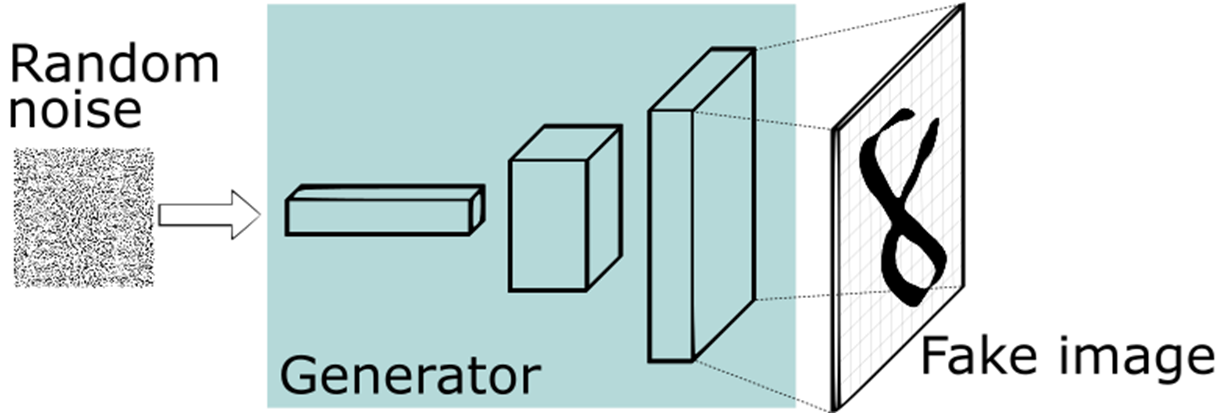


### **(2) Discriminator module**
- (784,) input to Fully connected layer -> predict 0(fake) or 1(real)


In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(int(n_channels*img_size*img_size), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

    def forward(self, img):
        out = self.model(img.view(img.size(0), -1))
        out = out.view(-1)
        return out

self.model
```
self.model = nn.Sequential(
    nn.Linear(int(n_channels*img_size*img_size), 512),
    nn.LeakyReLU(0.2, inplace=True),
    nn.Linear(512, 256),
    nn.LeakyReLU(0.2, inplace=True),
    nn.Linear(256, 1),
    nn.Sigmoid(),
)
```
- 첫 번째 layer에서 input을 1차원 벡터로 변환하여 512차원으로 줄임. + LeakyReLU
- 두 번째 layer에서 256차원으로 줄임. + LeakyReLU
- 세 번째 layer에서 최종 출력을 1차원으로 줄임.
- Sigmoid 함수를 통해서 판별 결과를 0과 1 사이의 값으로 변환!

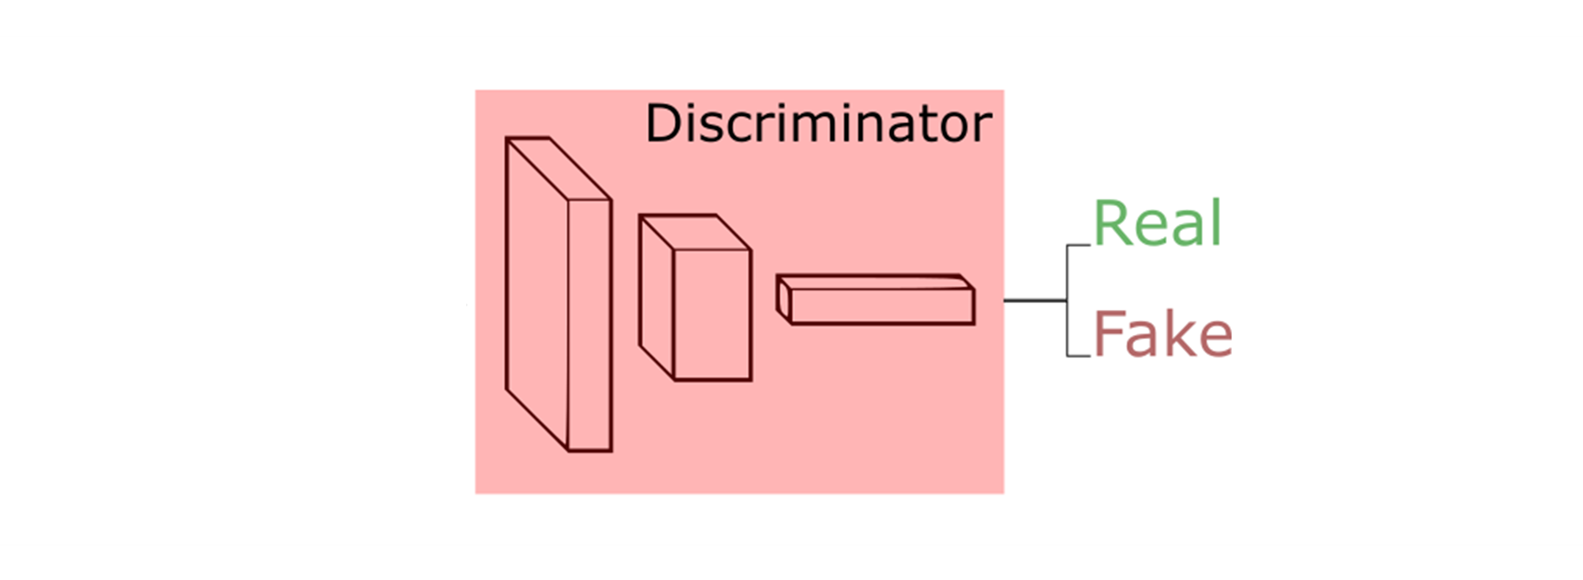

### **(3) Loss Function and Optimizer**


In [ ]:
lr = 0.0002

criterion = torch.nn.BCELoss()

generator = Generator().to(device)
discriminator = Discriminator().to(device)
generator.weight_init(mean=0.0,std=0.02)
discriminator.weight_init(mean=0.0,std=0.02)

g_optimizer = torch.optim.Adam(generator.parameters(), lr=lr)
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=lr)

**Loss function 설정:**
```
criterion = torch.nn.BCELoss()
```
- Binary Cross Entropy Loss 사용.
- Discriminator와 Generator 사이의 loss를 계산.

**Model Initialization:**
```
generator = Generator().to(device)
discriminator = Discriminator().to(device)
```
- Generator 모델과 Discriminator 모델 각각을 초기화

```
generator.weight_init(mean=0.0,std=0.02)
discriminator.weight_init(mean=0.0,std=0.02)
```
- Generator 모델과 Discriminator 모델의 가중치 초기화

**Optimizers:**
```
g_optimizer = torch.optim.Adam(generator.parameters(), lr=lr)
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=lr)
```
- Adam Optimizer 설정

### **(4) Discriminator train function**

In [ ]:
def train_discriminator(discriminator, generator, images):
    d_optimizer.zero_grad()

    real_images = images.to(device)
    real_labels_output = torch.ones(images.size(0)).to(device)

    real_validity = discriminator(real_images)
    real_loss = criterion(real_validity, real_labels_output)

    z = torch.randn(images.size(0), latent_dim).to(device)
    fake_images = generator(z)
    fake_labels_output =  torch.zeros(images.size(0)).to(device)

    fake_validity = discriminator(fake_images)
    fake_loss =  criterion(fake_validity, fake_labels_output)

    d_loss = real_loss + fake_loss
    d_loss.backward()
    d_optimizer.step()

    return d_loss.item()

**train&label:**
#####**Real image**
```
real_images = images.to(device)
real_labels_output = torch.ones(images.size(0)).to(device)
```
- Real image에 대한 Discriminator의 출력 결과가 1이 되어야 하므로, 크기가 'image.size(0)'인 1로 이루어진 tensor를 생성. **Real 레이블** 생성.

```
real_validity = discriminator(real_images)
```
- Real image를 Discriminator에 입력하여, Real image에 대한 판별 결과를 얻음. (== 해당 이미지가 Real image일 확률)

```
real_loss = criterion(real_validity, real_labels_output)
```
- criterion을 사용하여 Real image에 대한 Discriminator의 출력과 Real 레이블을 비교하여 loss 계산

#####**Fake image**
```
z = torch.randn(images.size(0), latent_dim).to(device)
```
- random noise vector z 생성.
- z == Generator의 input

```
fake_images = generator(z)
fake_labels_output = torch.zeros(images.size(0)).to(device)
```
- Generator에 z를 입력하여 Fake image 생성.
- Fake image에 대한 Discriminator의 **Fake 레이블** 생성, Fake image에 대한 Discriminator의 출력 결과는 0이 되어야 하므로,\
크기가 'images.size(0)'인 0으로 이루어진 tensor를 생성.

```
fake_validity = discriminator(fake_images)
```
- Fake image를 Discriminator에 입력했을 때 얻어지는 판별 결과 (== 해당 이미지가 Fake image일 확률)

```
fake_loss = criterion(fake_validity, fake_labels_output)
```
- criterion을 사용하여 Fake image에 대한 Discriminator의 출력과 Fake 레이블을 비교하여 loss 계산.

**최종**
```
d_loss = real_loss + fake_loss
d_loss.backward()
d_optimizer.step()
```
- total Discriminator loss = Real loss + Fake loss

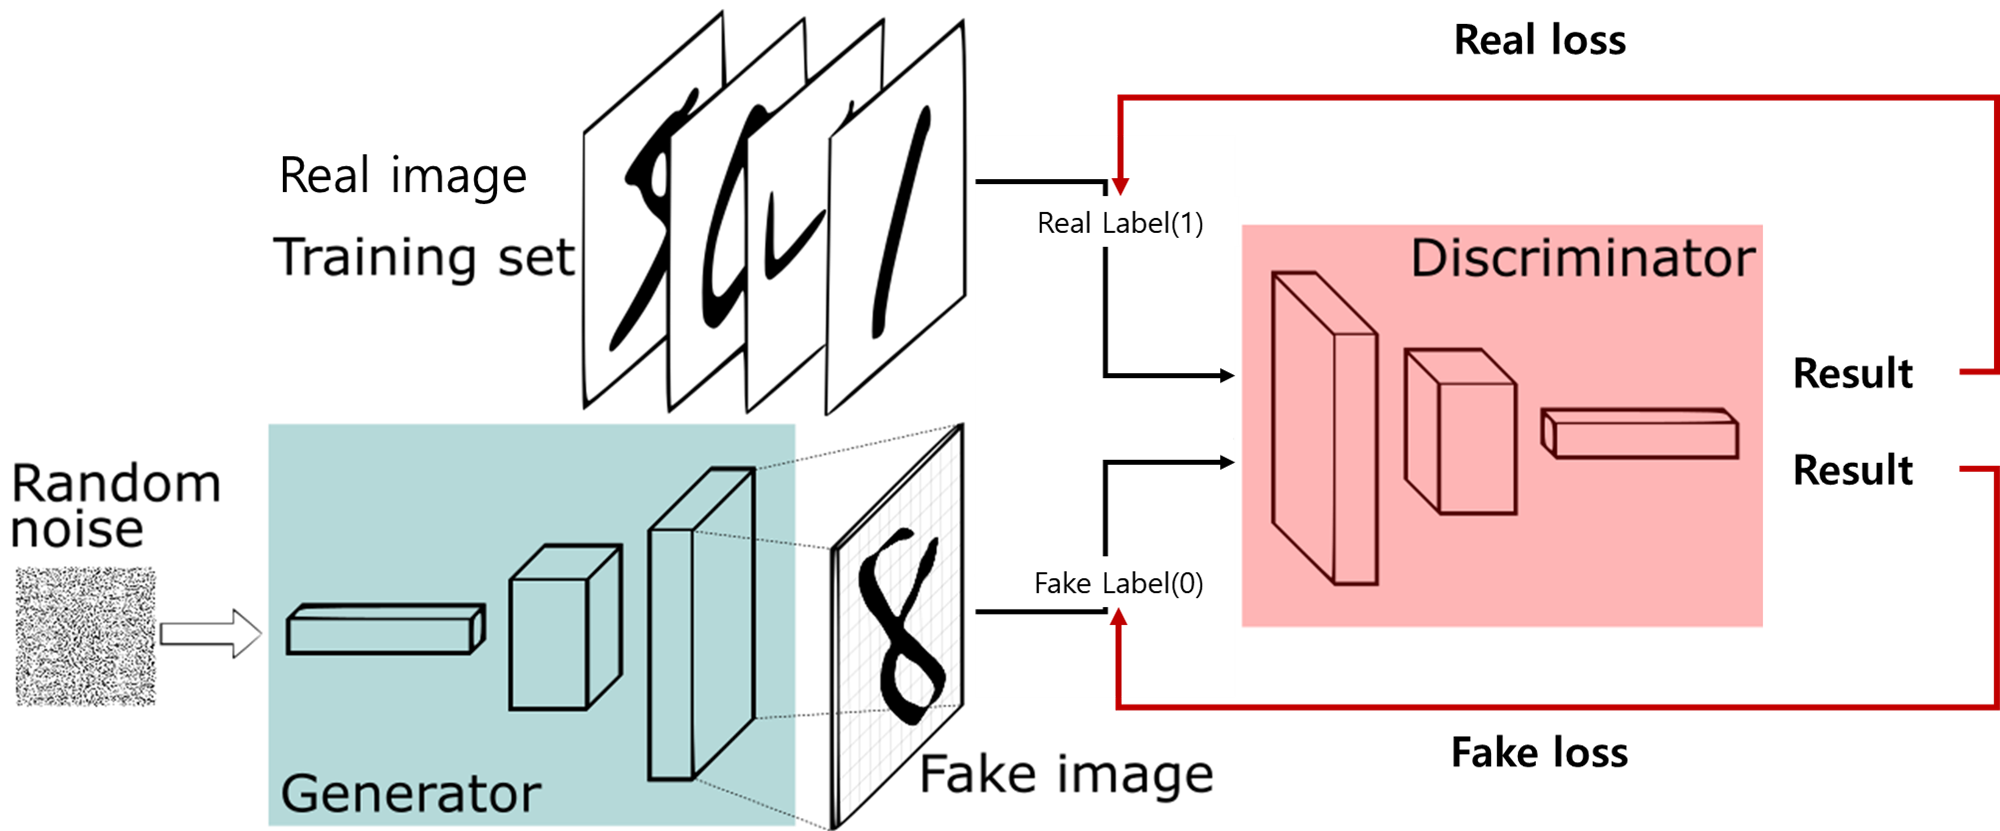

### **(5) Generator train function**

In [ ]:
def train_generator(generator, discriminator, batch_size):
    g_optimizer.zero_grad()

    real_labels_output = torch.ones(batch_size).to(device)

    z = torch.randn(batch_size, latent_dim).to(device)
    fake_images = generator(z)

    fake_validity = discriminator(fake_images)
    g_loss = criterion(fake_validity, real_labels_output)

    g_loss.backward()
    g_optimizer.step()

    return g_loss.item()

```
real_labels_output = torch.ones(batch_size).to(device)
```
- Fake image를 생성할 때 사용하는 레이블 생성.
- Fake image에 대한 Discriminator의 출력을 1로 만들기 위해 사용.

```
z = torch.randn(batch_size, latent_dim).to(device)
fake_images = generator(z)
```
- noise vector z를 생성.
- batch_size: 한 번에 생성할 Fake image의 수
- latent_dim: Generator의 noise vector의 차원

```
fake_validity = discriminator(fake_images)
g_loss = criterion(fake_validity, real_labels_output)
```
- 생성된 Fake image를 Discriminator에 입력하여 Fake image에 대한 판별 결과를 얻게 됨. (== 해당 이미지가 Real image로 판별될 확률)
- Fake image에 대한 Discriminator의 출력과 label(==1) 사이의 loss 계산!

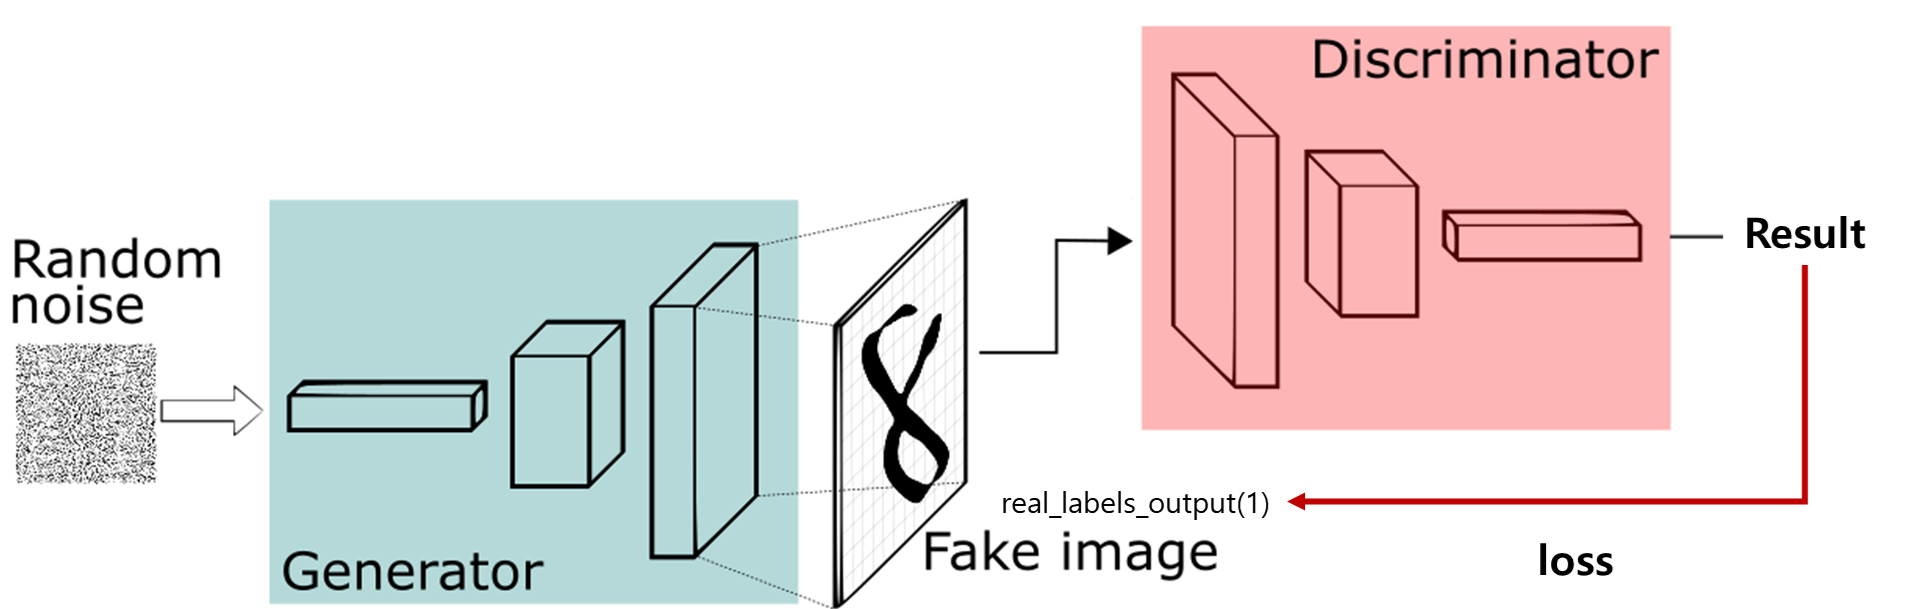

### **(6) GAN training**

In [ ]:
def test_plot(num_test_samples,plot_axis,generator,latent_dim):
    (a,b) = plot_axis
    test_noise = torch.randn(num_test_samples, latent_dim).to(device)
    fig,axes = plt.subplots(b,a,figsize=(2*a,2.5*b))

    test_images = generator(test_noise)

    for i in range(num_test_samples):
        ax = axes[i//a,i%a]
        ax.imshow(test_images[i,:].data.cpu().numpy().reshape(img_size, img_size),cmap='gray')

    plt.show()

In [ ]:
D_losses = []
G_losses = []

n_epochs = 50

for epoch in tqdm(range(n_epochs)):
    d_avg_loss = 0
    g_avg_loss = 0

    for n, (images, _) in enumerate(train_loader):

        d_loss = train_discriminator(discriminator, generator, images)
        g_loss = train_generator(generator, discriminator, batch_size)

        d_avg_loss += d_loss
        g_avg_loss += g_loss

    d_avg_loss /= len(train_loader)
    g_avg_loss /= len(train_loader)
    D_losses.append(d_avg_loss)
    G_losses.append(g_avg_loss)

    print('Epoch [%3d/%3d], Step[%3d/%3d], d_loss: %.4f, g_loss: %.4f'
          %(epoch + 1, n_epochs, n+1, len(train_loader), d_avg_loss, g_avg_loss))

In [ ]:
test_plot(num_test_samples=8,plot_axis=(4,2),generator=generator,latent_dim=latent_dim)

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

###**Result**

**epoch = 0**

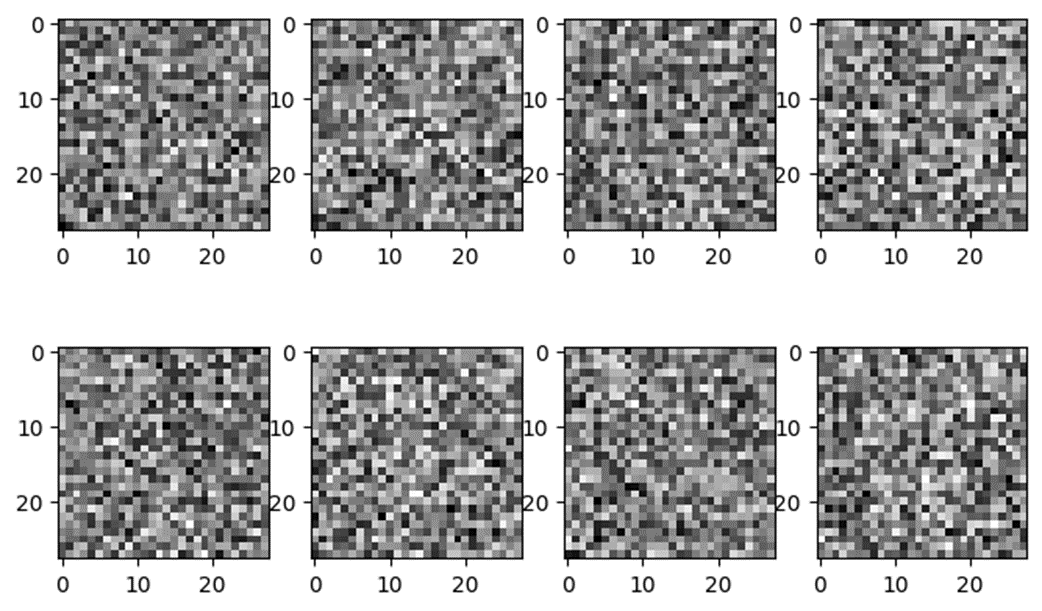

**epoch = 10**

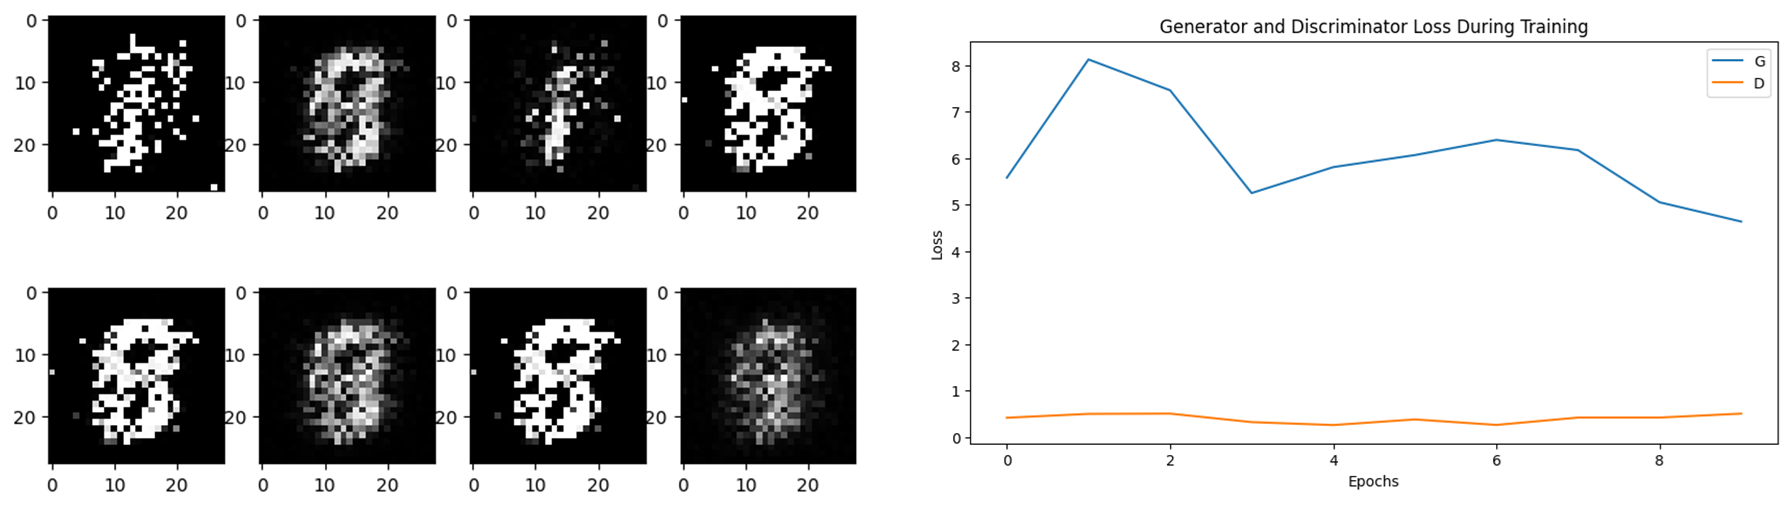

**epoch = 30**

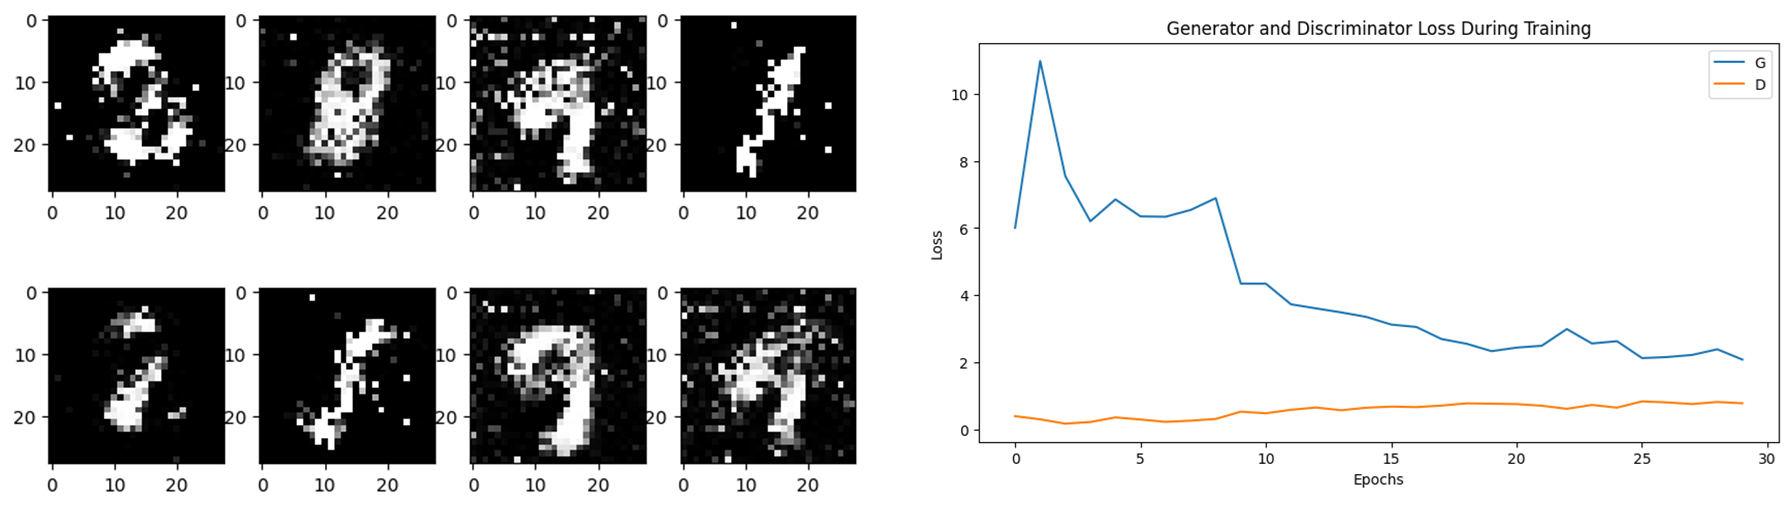

**epoch = 100**

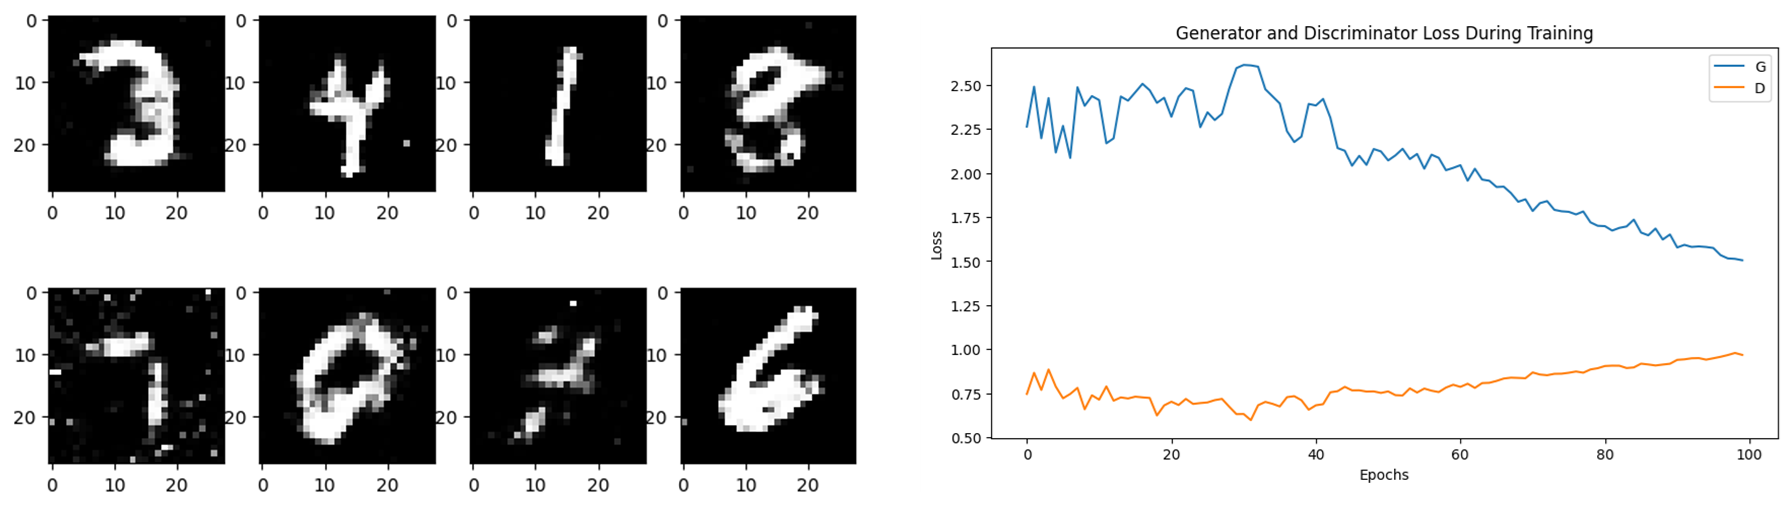

**epoch = 300**

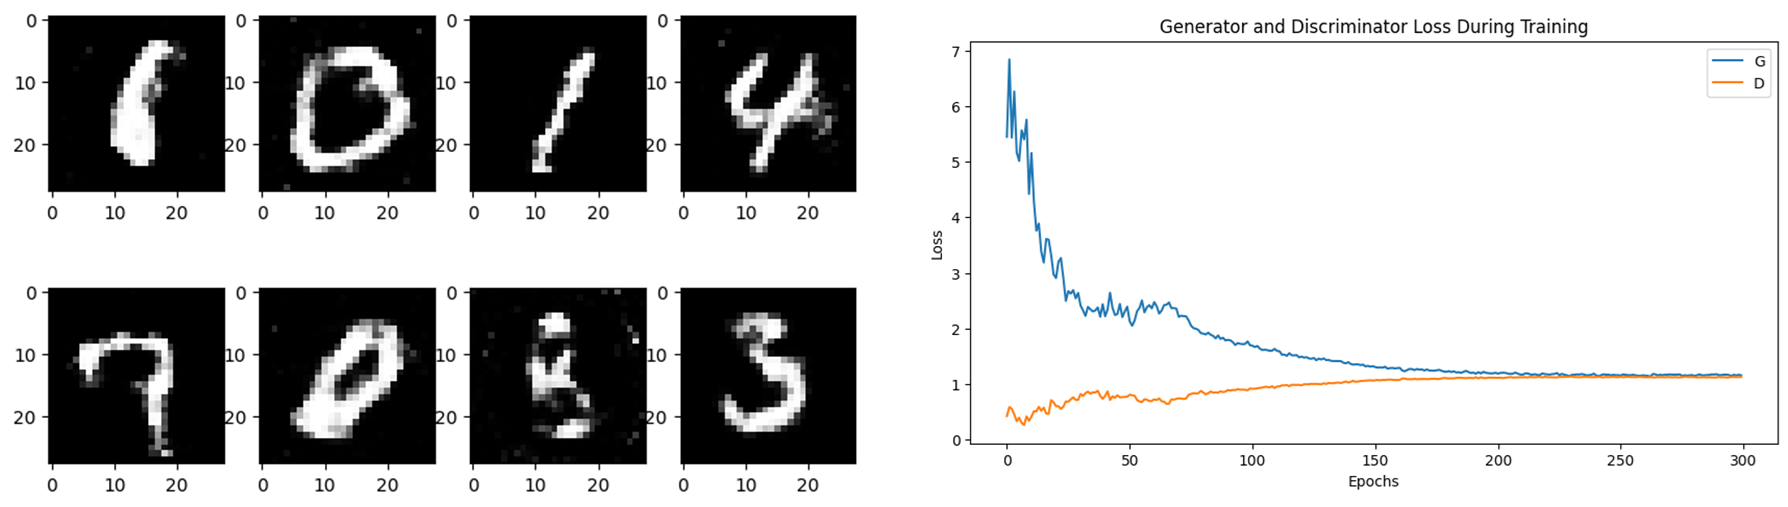

##**DCGAN 구현**

관련 논문: DCGAN - Deep Convolutional Generative Adversarial Nets (ICLR 2016)\
(Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks - Alec Radford el ec, 2016)

###**0. 모델 구조**

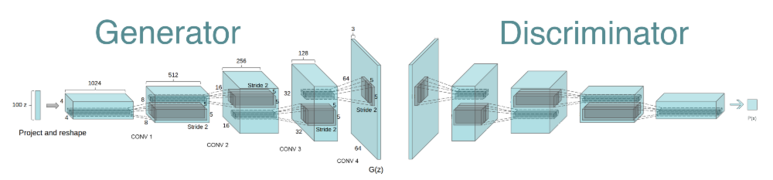

###**1. 라이브러리 임포트**

In [ ]:
import argparse
import os
import numpy as np
import math
import itertools
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import seaborn as sn

import torchvision.transforms as transforms
from torchvision import datasets

import torch
from torch.utils.data import DataLoader
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

### **2. Hyperparameter 설정**

- latent_dim = 100: Random noise z의 차원을 100으로 설정
- normal_init: 네트워크 가중치를 정규 분포로 초기화



In [ ]:
batch_size = 128
img_size = 28
n_channels = 1
n_classes = 10

latent_dim = 100

device = 'cuda' if torch.cuda.is_available() else 'cpu'

seed = 5
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

def normal_init(m, mean, std):
    if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
        m.weight.data.normal_(mean, std)
        m.bias.data.zero_()

### **3. MNIST Dataset 로드**

- MNIST dataset:\
28x28 pixel 흑백 필기체 이미지 6만 개 -> 32x32로 변경해서 구현

In [ ]:
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])

mnist_train = datasets.MNIST(root='data', download=True, train=True, transform=transform)
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True)

In [ ]:
fig,axes = plt.subplots(2,5,figsize=(2*5,2.5*2))

examples = enumerate(train_loader)
_, (ex_data, ex_targets) = next(examples)

for i in range(10):
    ax = axes[i//5,i%5]
    ax.imshow(ex_data[i][0],cmap='gray')
    ax.set_title('Label: {}'.format(ex_targets[i]))

plt.show()

### **4. DCGAN 구현**

- Generator: noise z를 가지고 Fake image 생성!
- Discriminator: Real image와 Fake image 구분!\
Real로 판별하면 1, Fake로 판별하면 0 으로 라벨링
- DCGAN이므로, Fullcy Connected Layers들을 Convolutional Layers로 변경!

### **(1) Generator module**


In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.model = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 1024, 4, 1, 0, bias=False),
            nn.BatchNorm2d(1024),
            nn.ReLU(True),
            nn.ConvTranspose2d(1024, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 1, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        return img


### **(2) Discriminator module**


In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Conv2d(1, 256, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1024, 4, 2, 1, bias=False),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(1024, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, img):
        validity = self.model(img)
        return validity.view(-1, 1)

### **(3) Loss Function and Optimizer**


In [ ]:
lr = 0.0002

criterion = torch.nn.BCELoss()

generator = Generator().to(device)
discriminator = Discriminator().to(device)
generator.weight_init(mean=0.0,std=0.02)
discriminator.weight_init(mean=0.0,std=0.02)

g_optimizer = torch.optim.Adam(generator.parameters(), lr=lr)
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=lr)

### **(4) Discriminator train function**

In [ ]:
def train_discriminator(discriminator, generator, images):
    d_optimizer.zero_grad()

    real_images = images.to(device)
    real_labels_output = torch.ones((images.size(0),1)).to(device)

    real_validity = discriminator(real_images)
    real_loss = criterion(real_validity, real_labels_output)

    z = torch.randn(images.size(0), latent_dim, 1, 1).to(device)
    fake_images = generator(z)
    fake_labels_output =  torch.zeros((images.size(0),1)).to(device)

    fake_validity = discriminator(fake_images)
    fake_loss =  criterion(fake_validity, fake_labels_output)

    d_loss = real_loss + fake_loss
    d_loss.backward()
    d_optimizer.step()

    return d_loss.item()

### **(5) Generator train function**

In [ ]:
def train_generator(generator, discriminator, batch_size):
    g_optimizer.zero_grad()

    real_labels_output = torch.ones((batch_size,1)).to(device)

    z = torch.randn(batch_size, latent_dim, 1, 1).to(device)
    fake_images = generator(z)

    fake_validity = discriminator(fake_images)
    g_loss = criterion(fake_validity, real_labels_output)

    g_loss.backward()
    g_optimizer.step()

    return g_loss.item()

### **(6) GAN training**

In [ ]:
def test_plot(num_test_samples, plot_axis, generator, latent_dim):
    (a, b) = plot_axis
    test_noise = torch.randn(num_test_samples, latent_dim, 1, 1).to(device)
    fig, axes = plt.subplots(b, a, figsize=(2 * a, 2.5 * b))

    with torch.no_grad():
        test_images = generator(test_noise)

    for i in range(num_test_samples):
        ax = axes[i // a, i % a]
        ax.imshow(test_images[i, 0].cpu().numpy(), cmap='gray')

    plt.show()

In [ ]:
D_losses = []
G_losses = []

n_epochs = 5

for epoch in tqdm(range(n_epochs)):
    d_avg_loss = 0
    g_avg_loss = 0

    for n, (images, _) in enumerate(train_loader):

        d_loss = train_discriminator(discriminator, generator, images)
        g_loss = train_generator(generator, discriminator, batch_size)

        d_avg_loss += d_loss
        g_avg_loss += g_loss

    d_avg_loss /= len(train_loader)
    g_avg_loss /= len(train_loader)
    D_losses.append(d_avg_loss)
    G_losses.append(g_avg_loss)

    print('Epoch [%3d/%3d], Step[%3d/%3d], d_loss: %.4f, g_loss: %.4f'
          %(epoch + 1, n_epochs, n+1, len(train_loader), d_avg_loss, g_avg_loss))

In [ ]:
test_plot(num_test_samples=8,plot_axis=(4,2),generator=generator,latent_dim=latent_dim)

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

###**Result**

**epoch = 0**

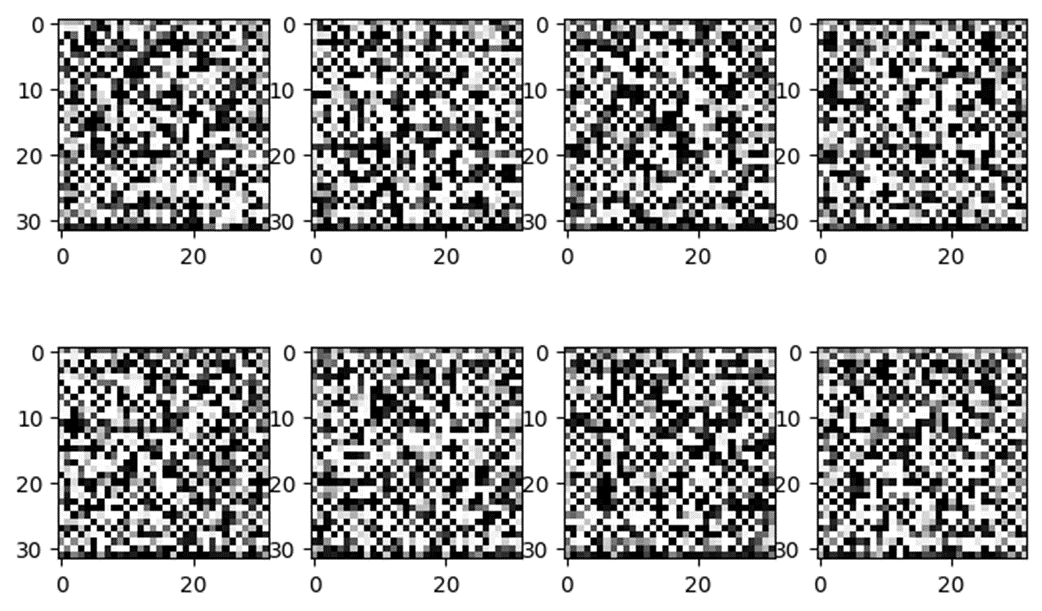

**epoch = 10**

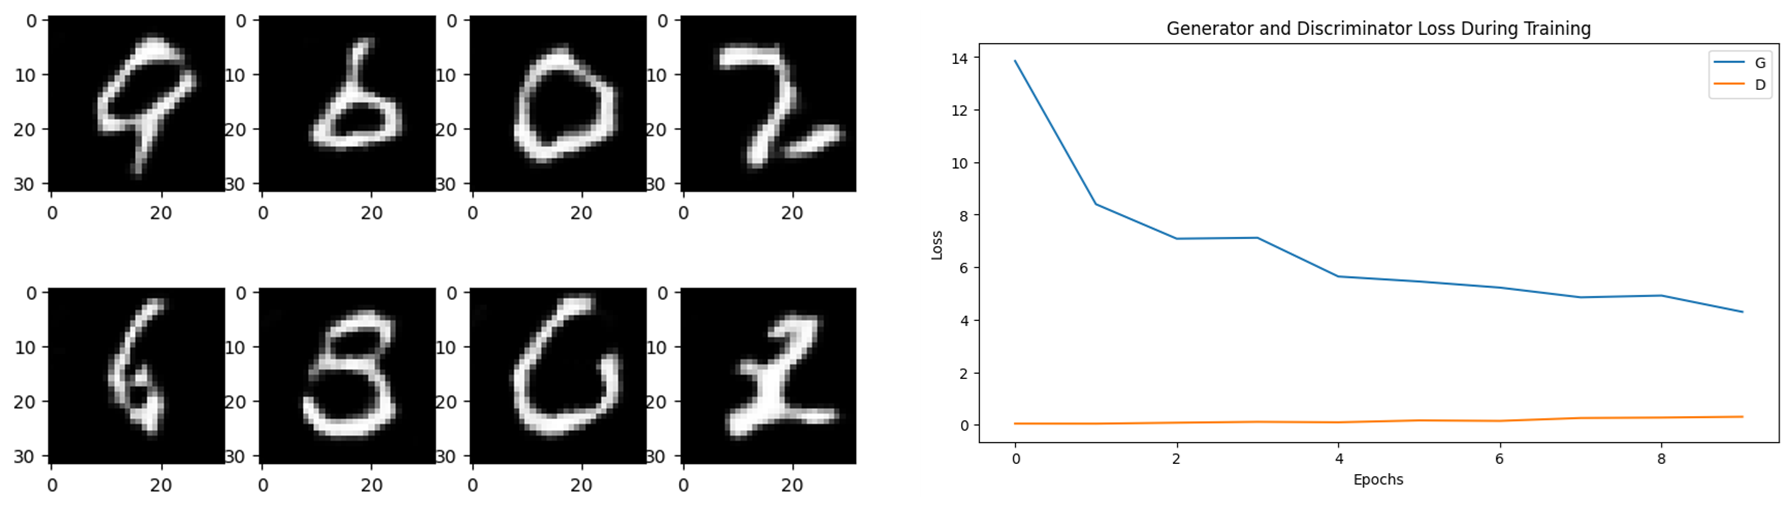

**epoch = 30**

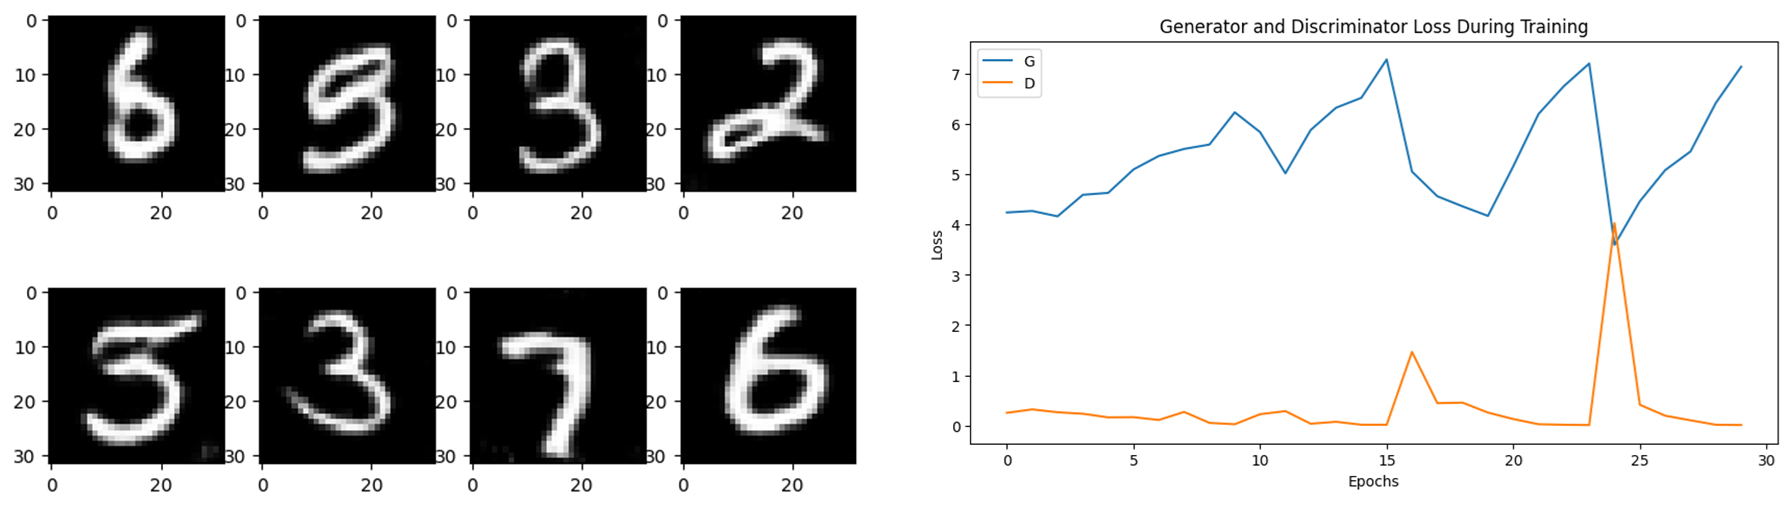